In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [31]:
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

In [32]:
image, label = train_dataset[0]
print(image.shape)
print(len(train_dataset))

torch.Size([1, 28, 28])
60000


In [33]:
image, label = test_dataset[0]
print(image.shape)
print(len(test_dataset))

torch.Size([1, 28, 28])
10000


In [34]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [35]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1=nn.Linear(128*3*3,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
        x=self.pool(torch.relu(self.conv1(x)))
        x=self.pool(torch.relu(self.conv2(x)))
        x=self.pool(torch.relu(self.conv3(x)))
        x=x.view(x.size(0),-1)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return x

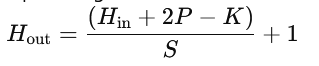

In [36]:
from torchsummary import summary
model = CNNClassifier()
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                  [-1, 128]         147,584
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 10]             650
Total params: 249,162
Trainable params: 249,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 0.95
Estimated Total Size (MB): 1.37
-------------------------------------------

In [37]:
model =CNNClassifier()
criterion =nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(), lr=0.001)

In [38]:
train_model(model, train_loader)

Epoch [1/3], Loss: 0.4696
Epoch [2/3], Loss: 0.2894
Epoch [3/3], Loss: 0.2420


In [39]:
def train_model(model, train_loader, num_epochs=3):
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [50]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total


    print("Name : R.Jayasree")
    print("Register Number : 212223040074")
    print(f'Test Accuracy: {accuracy:.4f}')


    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



    print("Name : R.Jayasree")
    print("Register Number : 212223040074")


    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Name : R.Jayasree
Register Number : 212223040074
Test Accuracy: 0.8997


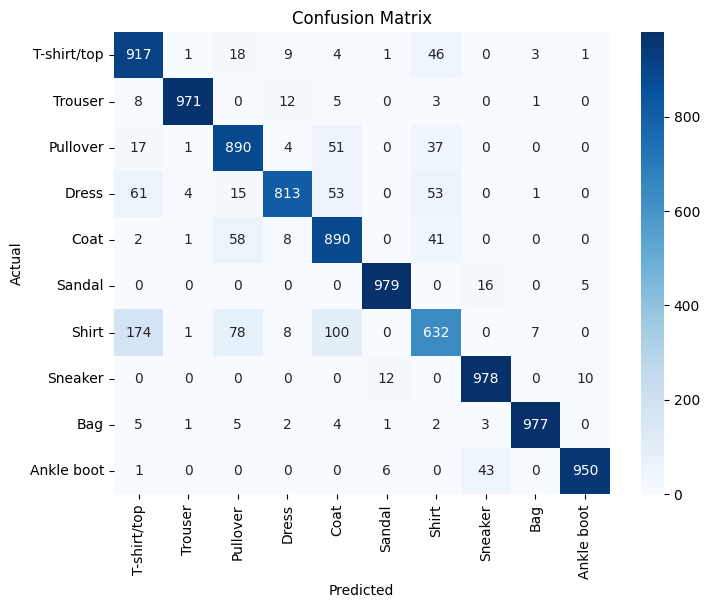

Name : R.Jayasree
Register Number : 212223040074
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.92      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.89      0.86      1000
       Dress       0.95      0.81      0.88      1000
        Coat       0.80      0.89      0.84      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.78      0.63      0.70      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [51]:
test_model(model, test_loader)


In [42]:
import matplotlib.pyplot as plt
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes

    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()
    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}')


Name : R.Jayasree
Register Number : 212223040074


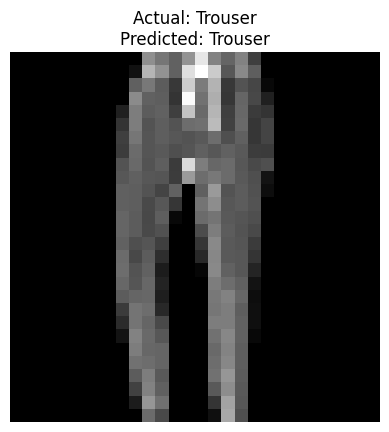

Actual: Trouser, Predicted: Trouser


In [52]:
print("Name : R.Jayasree")
print("Register Number : 212223040074")
predict_image(model, image_index=80, dataset=test_dataset)